#### Goals:

1. investigate prediction and probability outputs of mod0

2. produce a tool to go from flat probabilities to predictions that match the input (i.e. 9 columns of string labels) so that standard sklearn metrics can be applied.

3. make this an importable function for later use (python/flat_to_labels.py).

#### The classification scheme in the DrivenData tutorial approach

The DrivenData tutorial takes the following steps to create a classifier for a 9-target, multilabel problem:

1. One-hot encode target 
    * input:  9 targets of string labels 
    * output: 104 columns of binary labels


2. Classify using OneVsAll(LogisticRegression())
    * inputs: 104 columns of binary targets and  feature columns
    * outputs: model, predictions, probabilities

In the competition framework, the goal is to minimize log loss.  Log loss uses the probability predictions and DrivenData provides a custom log loss metric (see *python/dd_mmll.py*) that normalizes within groups of columns associated with each target. 

The OneVsAll(LogisticRegression()) approach creates 104 separate binary classifiers, each of which takes no note of the larger problem context.  A consequence of this method is that when outputs are predicted, each output is predicted independent of the others.  As a result, this classifier could predict as many as 104 1 outputs or as few as 0, while the nature of the problem suggests that there should be exactly 1 output for each set of binary labels representing one of the nine separate targets.

The issue is the same for the probability outputs of the classifiers.  The sum of the probabilites within a target grouping should be exactly 1.

This is the reason DrivenData's custom metric normalizes within the groups - to enforce the constraint that within a group, probabilities must sum to 1, but it should be noted that the OneVsAll classifier has no such constraint.

If this model is to be used to predict outputs (i.e. the actual labels, as opposed to probabilities), a similar approach must be taken.  Within a target group the label with highest probabilty should be predicted as 1 with all other labels predicted to be 0.

In order to produce meaningful probabilties and outputs, we need to do post-processing on the probabilities produced by OneVsRest(LogisticRegression()).

For this problem, to produce correct probabilty outputs, within each target group we need to normalize so that the sum of all the labels sum to 1 (as in the DrivenData metric).  To produce correct label outputs, using the corrected probabilies, select the highest probabilty label and predict 1, all others, predict 0.

#### Limitations of  aggregate log loss as metric for multi-target, multi-label problems

Log loss is a convenient metric for characterizing the overall performance of a model in multi-target, multi-label problems, in that it is a single number that captures some important aspects of model performance.

However, log loss averaged across all the targets, does not give a very interpretable assessment of where the model is doing well or poorly.  To create better models we would like to know where the model performing well or poorly.

The goal here is to take the probability output in the one-hot format and produce predictions that are expressed as labels.  With these predicted labels, the standard sklearn classification metrics can be used to assess how well or poorly the model is for on each target as well as the overall performance.

In [1]:
### in case I change anything under the covers, make it show up here.
%load_ext autoreload
%autoreload 2

#### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 60)

from timeit import default_timer as timer

In [3]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

In [4]:
# pipeline stuff
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize

In [5]:
# stuff in .python directory

### split ensuring train/test both have all labels
from python.multilabel import multilabel_train_test_split
### drivendata metric
from python.dd_mmll import multi_multi_log_loss, BOX_PLOTS_COLUMN_INDICES

In [6]:
def plot_cm(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(np.arange(cm.shape[0])); 
    ax.yaxis.set_ticklabels(np.arange(cm.shape[0]));

In [7]:
# these are the indices for each of the 9 targets after one-hot encoding
BOX_PLOTS_COLUMN_INDICES = [slice(0, 37),
                            slice(37, 48),
                            slice(48, 51),
                            slice(51, 76),
                            slice(76, 79),
                            slice(79, 82),
                            slice(82, 87),
                            slice(87, 96),
                            slice(96, 104)]

In [8]:
BPCI = BOX_PLOTS_COLUMN_INDICES

__============================ End of preliminaries =======================__

In [9]:
# Get data.  Might want this for the labels
df = pd.read_csv('data/TrainingData.csv', index_col=0)

In [10]:
# take a look at some labels within one target
df['Object_Type'].value_counts()

Base Salary/Compensation       97670
Benefits                       85467
NO_LABEL                       69644
Other Compensation/Stipend     61685
Supplies/Materials             31935
Substitute Compensation        27357
Contracted Services             7512
Other Non-Compensation          6297
Travel & Conferences            5030
Equipment & Equipment Lease     4460
Rent/Utilities                  3220
Name: Object_Type, dtype: int64

In [11]:
# These are actually the targets, not labels.
LABELS = sorted(['Function',  'Use',  'Sharing',  'Reporting',  'Student_Type',  'Position_Type', 
          'Object_Type',  'Pre_K',  'Operating_Status'])

In [12]:
LABELS

['Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Use']

In [13]:
# look at all the columns in the data; the targets are left-most
df.columns

Index(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status',
       'Object_Description', 'Text_2', 'SubFund_Description',
       'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description',
       'Location_Description', 'FTE', 'Function_Description',
       'Facility_or_Department', 'Position_Extra', 'Total',
       'Program_Description', 'Fund_Description', 'Text_1'],
      dtype='object')

In [14]:
### the names of the dummies
col_labels = pd.get_dummies(df[LABELS],  prefix_sep='__').columns; col_labels

Index(['Function__Aides Compensation',
       'Function__Career & Academic Counseling', 'Function__Communications',
       'Function__Curriculum Development',
       'Function__Data Processing & Information Services',
       'Function__Development & Fundraising', 'Function__Enrichment',
       'Function__Extended Time & Tutoring',
       'Function__Facilities & Maintenance', 'Function__Facilities Planning',
       ...
       'Student_Type__Special Education', 'Student_Type__Unspecified',
       'Use__Business Services', 'Use__ISPD', 'Use__Instruction',
       'Use__Leadership', 'Use__NO_LABEL', 'Use__O&M',
       'Use__Pupil Services & Enrichment', 'Use__Untracked Budget Set-Aside'],
      dtype='object', length=104)

In [15]:
# save the labels for the dummy variables in a dictionary
the_labels = {target : np.array(pd.get_dummies(df[target]).columns) for target in LABELS}; the_labels

{'Function': array(['Aides Compensation', 'Career & Academic Counseling',
        'Communications', 'Curriculum Development',
        'Data Processing & Information Services',
        'Development & Fundraising', 'Enrichment',
        'Extended Time & Tutoring', 'Facilities & Maintenance',
        'Facilities Planning',
        'Finance, Budget, Purchasing & Distribution', 'Food Services',
        'Governance', 'Human Resources',
        'Instructional Materials & Supplies', 'Insurance', 'Legal',
        'Library & Media', 'NO_LABEL', 'Other Compensation',
        'Other Non-Compensation', 'Parent & Community Relations',
        'Physical Health & Services', 'Professional Development',
        'Recruitment', 'Research & Accountability',
        'School Administration', 'School Supervision', 'Security & Safety',
        'Social & Emotional',
        'Special Population Program Management & Support',
        'Student Assignment', 'Student Transportation',
        'Substitute Compensation

In [16]:
# grab the saved outputs of mod0
mod0_out = np.load('./model_out/mod0.npz')

In [17]:
# look at keys
mod0_out.keys()

['m0_train_probas',
 'm0_train_yhat',
 'm0_y_train',
 'm0_test_probas',
 'm0_test_yhat',
 'm0_y_test']

#### Take a look at the prediction output of mod0.  They don't seem right.

In the first target, mod0.predict() only produces 592 ones where we ought to find one positive prediction for each row of inputs.

In [18]:
# check shape
mod0_out['m0_test_probas'].shape

(80055, 104)

In [19]:
# get hands on test yhat, i.e. the predictions; this is what we want to turn into 9 columns of labels.
m0_test_yhat = mod0_out['m0_test_yhat']

In [20]:
# yep, that's the shape
m0_test_yhat.shape

(80055, 104)

In [21]:
### How many 0s/1s in first target?  There are 592.
np.unique(m0_test_yhat[:, :37], return_counts=True)

(array([0, 1]), array([2961443,     592], dtype=int64))

####   Now look at the corresponding probabilities

In [22]:
### look at corresponding probas.
m0_test_probas = mod0_out['m0_test_probas']

In [23]:
### just the first target
m0tp_Function = m0_test_probas[:, :37]

In [24]:
### okay, that's the right shape
m0tp_Function.shape

(80055, 37)

#### Look at the row sums of the probabilities within a target.  Aggregate probability for row should sum to 1.0.

Row sums is a red herring.  Because each column is independent, it can have a probability between 0 and 1.  The row sum is the sum of the these probabilities and it can be more than 1 (it could be up to num_cols).  There's no constraint on this within one-vs-rest framework.

In [25]:
# get the row sums
m0tp_Function_row_sums = np.sum(m0tp_Function, axis=1)

In [26]:
# that's the right number of rows
m0tp_Function_row_sums.shape

(80055,)

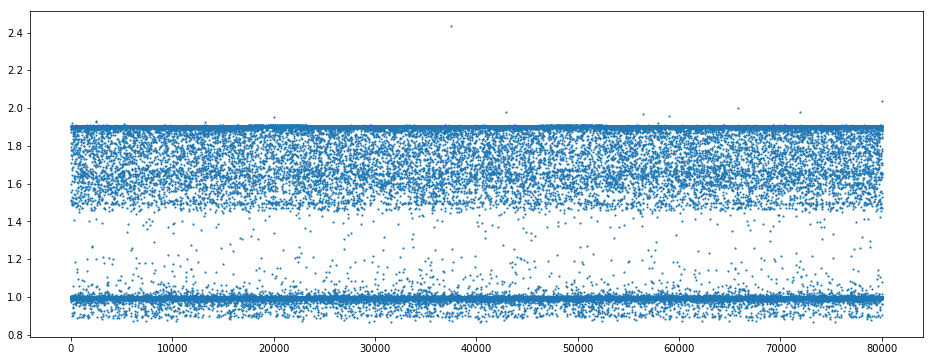

In [27]:
# plot the row sums
plt.figure(figsize=(16, 6))
plt.scatter(np.arange(80055), m0tp_Function_row_sums, marker='.', s=5);
# plt.xlim(0, 100)

#### That is a strange picture.

It has predicted these columns independently, so, yes, the row sums of probabilities can be more than 1.  DD said they would normalize within labels in the metric.

But I'm confused that when the model is called on to predict, it predicts only 592 labels, where we're looking for 80k (i.e. one per sample).



####  Maybe a better question is the following:  In the first target (37 columns) how many rows have an entry with probabilty > 0.5?

In [28]:
np.sum(m0_test_probas[:, :37] > 0.5)

592

###  This is how the model predicts.  It might predict more than one label within a target.  That would be bad.  It can also predict no labels.

I __*think*__ that if you use logistic regression in a multilabel fashion, logreg enforces the constraint that the sum of probabilities for all label (for a sample) is one.  It predicts by selecting the highest probabilty label.  We need to do the same.

In [29]:
m0tp_Function_normalized = m0tp_Function/np.sum(m0tp_Function, axis=1, keepdims=True)

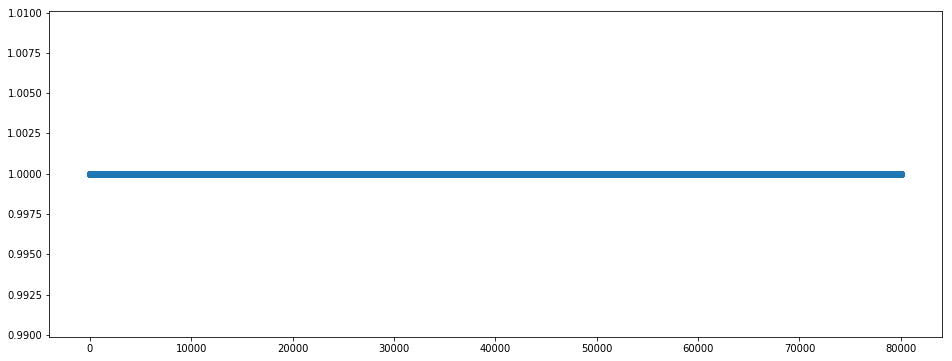

In [30]:
# plot the normalized probabilities for label 'Function'

plt.figure(figsize=(16, 6))
plt.scatter(np.arange(80055), np.sum(m0tp_Function_normalized, axis=1));
# plt.xlim(0, 100)

#### See how many positive predictions result after normalizing the probabilities.

So if you do that you get even less labels (120 vs 592 before normalization).  We have to remember that 0.5 is the threshold for *binary* classification.   In multilabel classification, the most probable label is predicted.

In [31]:
np.sum(m0tp_Function_normalized >= 0.5)

120

##### Check how many 1s were predicted per row on average.

In [32]:
# give me the row sums
all_col_row_sums = np.sum(m0_test_yhat, axis=1, keepdims=True)

In [33]:
all_col_row_sums.shape

(80055, 1)

In [34]:
np.average(all_col_row_sums)

5.509799512834926

In [35]:
m0_test_yhat.sum()/80055

5.509799512834926

#### So it predicts about 5.5 labels per row on average.  We're looking for exactly 9 in every row.

It must do that because these are all the one-hot coded labels with > 0.5 probabilty.  It thinks it's predicting 104 different binary classifications.

#### Let's make an array with the same shape as yhat_proba that consists of  0.5 everywhere.  Then compare to yhat and also count number of occurences > 0.5 in each row.  Average that by row.

In [36]:
# array of 0.5
one_half = np.ones(m0_test_probas.shape) * 0.5

In [37]:
# these are the predictions
sb_ones = m0_test_probas > one_half

In [38]:
# check shape
sb_ones.shape

(80055, 104)

In [39]:
# says 1 in 20 is over 0.5 or they could all be 0.05, but the values in this array are either 1 or 0
np.average(sb_ones)

0.05297884146956659

In [40]:
# average number of ones in a row
np.average(np.sum(sb_ones, axis=1, keepdims=True))

5.509799512834926

In [41]:
# how many 1/0s in sb_ones
np.unique(sb_ones, return_counts=True)

(array([False,  True]), array([7884633,  441087], dtype=int64))

#### And there you have it.  That's definitive.  The model predicts 1 where the individual classifiers do and pays no attention to the fact that this is a hierarchical problem.

In [42]:
(sb_ones == m0_test_yhat).all()

True

###  The prediction tool

What we need to do is reverse the original dummy encoding of the labels.

But it needs to be done differently from what m0.predict() does.  Instead of comparing to 0.5, it should select the most probable label from the labels for each target and predict one for that label.

In [43]:
# take a look at the columns indices again
BPCI

[slice(0, 37, None),
 slice(37, 48, None),
 slice(48, 51, None),
 slice(51, 76, None),
 slice(76, 79, None),
 slice(79, 82, None),
 slice(82, 87, None),
 slice(87, 96, None),
 slice(96, 104, None)]

In [44]:
# check that sum of all labels for all targets is right
np.sum([len(x) for x in the_labels.values()])

104

In [45]:
# remind me what this looks like
the_labels

{'Function': array(['Aides Compensation', 'Career & Academic Counseling',
        'Communications', 'Curriculum Development',
        'Data Processing & Information Services',
        'Development & Fundraising', 'Enrichment',
        'Extended Time & Tutoring', 'Facilities & Maintenance',
        'Facilities Planning',
        'Finance, Budget, Purchasing & Distribution', 'Food Services',
        'Governance', 'Human Resources',
        'Instructional Materials & Supplies', 'Insurance', 'Legal',
        'Library & Media', 'NO_LABEL', 'Other Compensation',
        'Other Non-Compensation', 'Parent & Community Relations',
        'Physical Health & Services', 'Professional Development',
        'Recruitment', 'Research & Accountability',
        'School Administration', 'School Supervision', 'Security & Safety',
        'Social & Emotional',
        'Special Population Program Management & Support',
        'Student Assignment', 'Student Transportation',
        'Substitute Compensation

In [46]:
# build a small random input with the correct number of columns
test_case = np.random.randn(10, 104); test_case

array([[ 1.92843866,  0.96301845,  0.52120362, ...,  0.15998248,
         1.37254686,  0.44514501],
       [-0.70269207,  1.02506106, -0.80576858, ...,  1.52546617,
         0.92925398, -0.75413769],
       [-0.76708121, -0.32171032, -1.26033232, ..., -0.60444519,
         0.03586943, -1.0404113 ],
       ...,
       [ 0.15441199, -0.44320498,  0.9859913 , ..., -0.48817907,
         0.59707065,  0.72856935],
       [ 0.10795906,  1.02987783, -0.89603561, ..., -0.40694795,
        -1.76668148,  0.37080699],
       [ 1.07550481,  0.78474139,  0.06916617, ..., -0.14370114,
        -0.46303034,  0.08239344]])

In [47]:
# make sure I can get at the pieces
test_case[:, BPCI[1]].shape

(10, 11)

In [48]:
# LABELS = [Function]

# indices is the set of slices that correspond to the labels (actually they're targets, not labels)
# the_labels is a dictionary mapping target name to array of labels for this target
def flat_to_labels(probas, indices=BPCI, targets=np.array(LABELS), the_labels=the_labels):
    ''' input: array of probabilities             (n_samples, 104), between 0 and 1
        output: an array of predictions of labels (n_samples, 9),   string label.   '''
    # 
    num_cols = len(targets)
    # probably won't need this
    num_rows = probas.shape[0]
    # make a place to put the output arrays
    the_outputs = []
    for idx, targ in enumerate(targets):
        out_col = the_labels[targ][np.argmax(probas[:, BPCI[idx]], axis=1)].reshape(-1, 1)
        the_outputs.append(out_col)
    return np.concatenate(the_outputs, axis=1)

####  Looks like this might be working...

In [49]:
flat_to_labels(test_case)

array([['Security & Safety', 'Supplies/Materials',
        'Operating, Not PreK-12', 'Occupational Therapist', 'PreK',
        'NO_LABEL', 'School on Central Budgets', 'Unspecified',
        'Pupil Services & Enrichment'],
       ['Facilities & Maintenance', 'Other Non-Compensation',
        'Non-Operating', 'Psychologist', 'Non PreK', 'Non-School',
        'Shared Services', 'Special Education', 'NO_LABEL'],
       ['Untracked Budget Set-Aside', 'Contracted Services',
        'PreK-12 Operating', 'Substitute', 'Non PreK', 'NO_LABEL',
        'School Reported', 'Poverty', 'Instruction'],
       ['Professional Development', 'Benefits', 'PreK-12 Operating',
        'Physical Therapist', 'NO_LABEL', 'School', 'School Reported',
        'NO_LABEL', 'Pupil Services & Enrichment'],
       ['NO_LABEL', 'Equipment & Equipment Lease', 'Non-Operating',
        'Social Worker', 'Non PreK', 'Non-School', 'School Reported',
        'ELL', 'NO_LABEL'],
       ['Parent & Community Relations', 'Travel

In [50]:
m0_test_predictions = flat_to_labels(m0_test_probas)

In [51]:
m0_test_predictions.shape

(80055, 9)

In [52]:
m0_test_predictions[:10,:]

array([['NO_LABEL', 'Benefits', 'PreK-12 Operating', 'NO_LABEL',
        'NO_LABEL', 'School', 'School Reported', 'Unspecified',
        'Instruction'],
       ['NO_LABEL', 'Benefits', 'PreK-12 Operating', 'NO_LABEL',
        'NO_LABEL', 'School', 'School Reported', 'Unspecified',
        'Instruction'],
       ['NO_LABEL', 'Benefits', 'PreK-12 Operating', 'NO_LABEL',
        'NO_LABEL', 'School', 'School Reported', 'Unspecified',
        'Instruction'],
       ['NO_LABEL', 'Benefits', 'PreK-12 Operating', 'NO_LABEL',
        'NO_LABEL', 'School', 'School Reported', 'Unspecified',
        'Instruction'],
       ['Substitute Compensation', 'Benefits', 'PreK-12 Operating',
        'Substitute', 'NO_LABEL', 'School', 'School Reported',
        'Unspecified', 'Instruction'],
       ['NO_LABEL', 'Benefits', 'PreK-12 Operating', 'NO_LABEL',
        'NO_LABEL', 'School', 'School Reported', 'Unspecified',
        'Instruction'],
       ['NO_LABEL', 'Benefits', 'PreK-12 Operating', 'NO_LABEL',


#### Okay, m0_y_test is one-hot encoded.  So I don't have the original input, only the one-hot.

But I can recreate it by running flat_to_labels.

#### get the input from the test set

In [53]:
m0_y_test = mod0_out['m0_y_test']

In [54]:
# check shapes
m0_y_test.shape, m0_test_predictions.shape

((80055, 104), (80055, 9))

In [55]:
# turn it back into targets/labels
m0_y_test_orig = flat_to_labels(m0_y_test)

In [56]:
# verify shapes
m0_y_test_orig.shape, m0_test_predictions.shape

((80055, 9), (80055, 9))

####  Now I should be able to run sklearn metrics on each target/prediction pair.

In [57]:
for idx, name in enumerate(LABELS): 
    score = accuracy_score(m0_y_test_orig[:, idx], m0_test_predictions[:, idx])
    print('Accuracy for {}: {:0.4f}'.format(name, score))

Accuracy for Function: 0.2760
Accuracy for Object_Type: 0.4253
Accuracy for Operating_Status: 0.8588
Accuracy for Position_Type: 0.3729
Accuracy for Pre_K: 0.7663
Accuracy for Reporting: 0.6410
Accuracy for Sharing: 0.6337
Accuracy for Student_Type: 0.5570
Accuracy for Use: 0.5082


#### These are the exact results I got from running LogisticRegression classifier on each target individually (see mod0_multiple_ways.ipynb for more background).